In [1]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# path to the directory
RAVD = "RAVDESS/Dataset/"
print(RAVD)

RAVDESS/Dataset/


In [3]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)

        
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: labels, dtype: int64

ValueError: could not convert string to float: 'male_neutral'

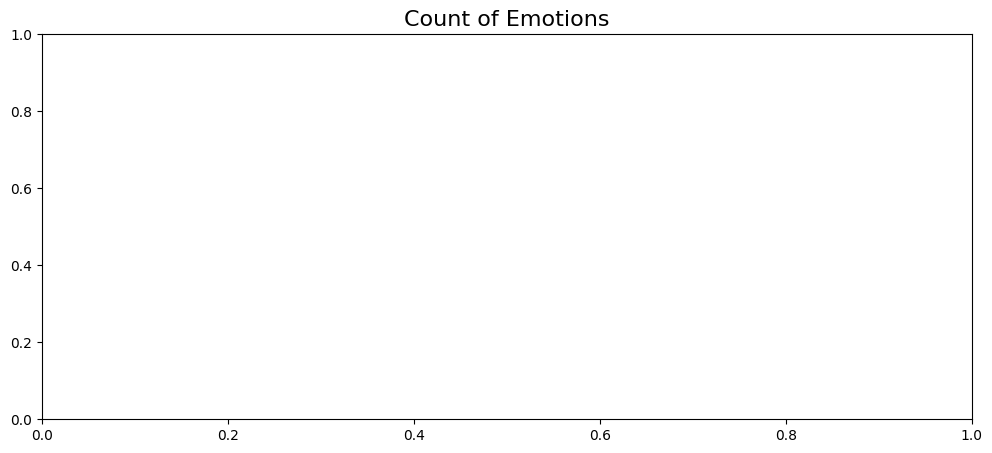

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [4]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data):
    return librosa.effects.time_stretch(data,rate=0.8)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=0.7)

In [6]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

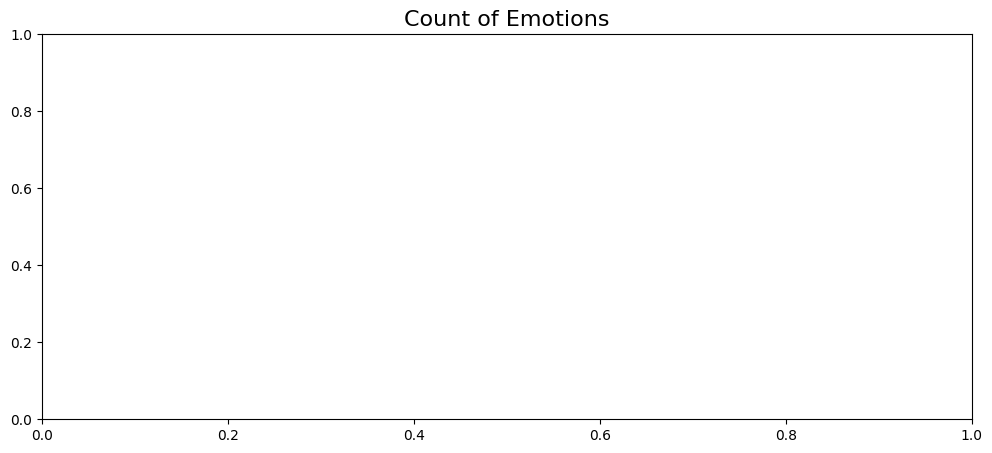

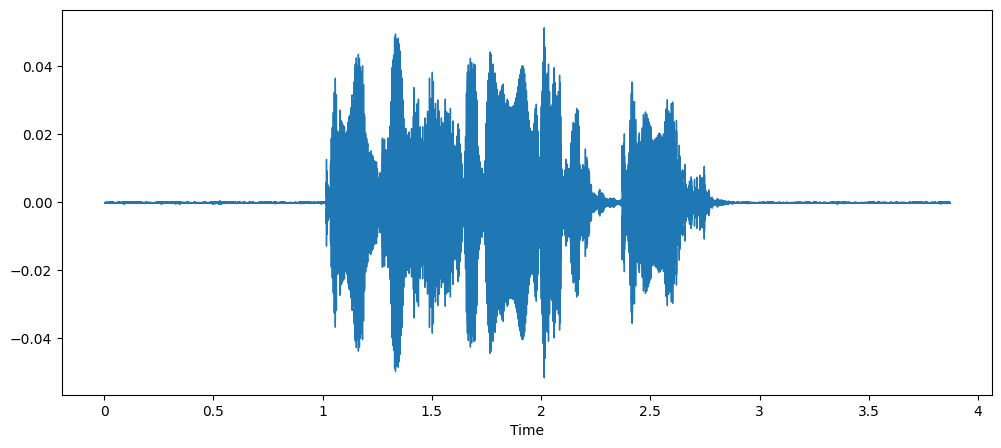

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [7]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

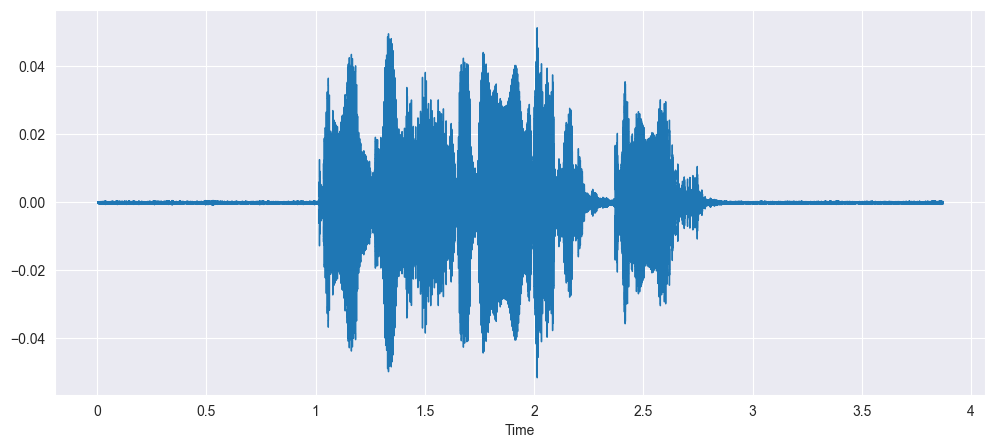

In [61]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [8]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [9]:
RAVD_df.head()

,labels,source,path
0,male_neutral,RAVDESS,RAVDESS/Dataset/Actor_01/03-01-01-01-01-01-01.wav
1,male_neutral,RAVDESS,RAVDESS/Dataset/Actor_01/03-01-01-01-01-02-01.wav
2,male_neutral,RAVDESS,RAVDESS/Dataset/Actor_01/03-01-01-01-02-01-01.wav
3,male_neutral,RAVDESS,RAVDESS/Dataset/Actor_01/03-01-01-01-02-02-01.wav
4,male_neutral,RAVDESS,RAVDESS/Dataset/Actor_01/03-01-02-01-01-01-01.wav


In [ ]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [65]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-645.880737,72.619637,0.841305,16.399446,10.241591,0.653901,-4.328002,-4.258932,-14.575824,-3.806285,...,-4.042665,2.519602,-4.972247,0.566447,1.035527,-5.416451,-2.449469,-1.782306,-1.212806,male_neutral
1,-572.551539,57.041747,2.132286,13.040611,7.850151,-0.752478,-4.694890,-6.795615,-13.433349,-5.321012,...,-3.529581,0.165437,-4.134358,-1.362220,-0.066289,-5.065811,-3.406286,-0.858399,-2.906791,male_neutral
2,-712.554077,70.982697,-0.730810,16.815830,7.990942,-0.822050,-6.391445,-6.146833,-15.975613,-0.313743,...,-3.398212,2.348455,-6.031178,1.242807,-1.837245,-5.671288,-3.115946,-1.071852,-4.964334,male_neutral
3,-634.663269,72.324066,-2.998578,20.209740,10.674217,-1.151011,-2.813592,-7.923956,-16.231958,-2.627547,...,-4.167823,0.719305,-4.954944,-0.688254,0.114427,-6.475232,-1.695712,-2.899729,0.377745,male_neutral
4,-461.509819,33.712541,7.997738,11.526592,5.791099,-0.888991,-2.412149,-7.594732,-10.495846,-5.674431,...,-1.988167,-1.248735,-2.042933,-0.872889,-0.054215,-3.479406,-3.121532,-0.769085,-1.827617,male_neutral


In [66]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-645.880737,72.619637,0.841305,16.399446,10.241591,0.653901,-4.328002,-4.258932,-14.575824,-3.806285,...,-4.042665,2.519602,-4.972247,0.566447,1.035527,-5.416451,-2.449469,-1.782306,-1.212806,male_neutral
1,-572.551539,57.041747,2.132286,13.040611,7.850151,-0.752478,-4.694890,-6.795615,-13.433349,-5.321012,...,-3.529581,0.165437,-4.134358,-1.362220,-0.066289,-5.065811,-3.406286,-0.858399,-2.906791,male_neutral
2,-712.554077,70.982697,-0.730810,16.815830,7.990942,-0.822050,-6.391445,-6.146833,-15.975613,-0.313743,...,-3.398212,2.348455,-6.031178,1.242807,-1.837245,-5.671288,-3.115946,-1.071852,-4.964334,male_neutral
3,-634.663269,72.324066,-2.998578,20.209740,10.674217,-1.151011,-2.813592,-7.923956,-16.231958,-2.627547,...,-4.167823,0.719305,-4.954944,-0.688254,0.114427,-6.475232,-1.695712,-2.899729,0.377745,male_neutral
4,-461.509819,33.712541,7.997738,11.526592,5.791099,-0.888991,-2.412149,-7.594732,-10.495846,-5.674431,...,-1.988167,-1.248735,-2.042933,-0.872889,-0.054215,-3.479406,-3.121532,-0.769085,-1.827617,male_neutral


In [67]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [68]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [69]:
# Train and Test Split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

In [70]:
# Reshape for LSTM 
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [71]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

In [72]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 14), (1080, 20, 1), (1080, 14))

In [73]:
#CNN
import tensorflow as tf 
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 2048)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 10, 2048)         8192      
 ormalization)                                                   
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 1024)          0         
 1D)                                                             
                                                        

In [74]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
51/51 [==============================] - 114s 2s/step - loss: 2.6207 - accuracy: 0.1090 - val_loss: 2.6328 - val_accuracy: 0.1111
Epoch 2/150
51/51 [==============================] - 106s 2s/step - loss: 2.5701 - accuracy: 0.1469 - val_loss: 2.6238 - val_accuracy: 0.1111
Epoch 3/150
51/51 [==============================] - 105s 2s/step - loss: 2.4977 - accuracy: 0.1725 - val_loss: 2.6036 - val_accuracy: 0.1111
Epoch 4/150
51/51 [==============================] - 101s 2s/step - loss: 2.4259 - accuracy: 0.2086 - val_loss: 2.5810 - val_accuracy: 0.1111
Epoch 5/150
51/51 [==============================] - 101s 2s/step - loss: 2.3635 - accuracy: 0.2074 - val_loss: 2.5437 - val_accuracy: 0.1139
Epoch 6/150
51/51 [==============================] - 101s 2s/step - loss: 2.2573 - accuracy: 0.2349 - val_loss: 2.5145 - val_accuracy: 0.1787
Epoch 7/150
43/51 [========================>.....] - ETA: 16s - loss: 2.2143 - accuracy: 0.2598

KeyboardInterrupt: 

In [ ]:
#CNN
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

In [ ]:
# #CNN
# epochs = [i for i in range(150)]
# fig , ax = plt.subplots(1,2)
# train_acc = history.history['accuracy']
# train_loss = history.history['loss']
# test_acc = history.history['val_accuracy']
# test_loss = history.history['val_loss']

# fig.set_size_inches(20,6)
# ax[0].plot(epochs , train_loss , label = 'Training Loss')
# ax[0].plot(epochs , test_loss , label = 'Testing Loss')
# ax[0].set_title('Training & Testing Loss')
# ax[0].legend()
# ax[0].set_xlabel("Epochs")

# ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
# ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
# ax[1].set_title('Training & Testing Accuracy')
# ax[1].legend()
# ax[1].set_xlabel("Epochs")
# plt.show()

In [ ]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
model_name = 'model3.h5'
save_dir = os.path.join('./', 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model3.h5")
print("Loaded model from disk")

In [ ]:
data, sampling_rate = librosa.load("RAVDESS/Dataset/Actor_01/03-01-02-02-02-01-01.wav")

In [ ]:
import os
import pandas as pd
import librosa
import glob 

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('RAVDESS/Dataset/Actor_01/03-01-02-02-02-01-01.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [ ]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

In [ ]:
livepreds

In [ ]:
livepreds.shape

In [ ]:
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions